# Chapter 48: Value Function Approximation

### This code generates figures 2, 3, 6, and 7 in Chapter 48: Value Function Approximation (vol. II)
TEXT: A. H. Sayed, INFERENCE AND LEARNING FROM DATA, Cambridge University Press, 2022.

<div style="text-align: justify">
DISCLAIMER:  This computer code is  provided  "as is"   without  any  guarantees.
Practitioners  should  use it  at their own risk.  While  the  codes in  the text 
are useful for instructional purposes, they are not intended to serve as examples 
of full-blown or optimized designs. The author has made no attempt at optimizing 
the codes, perfecting them, or even checking them for absolute accuracy. In order 
to keep the codes at a level  that is  easy to follow by students, the author has 
often chosen to  sacrifice  performance or even programming elegance in  lieu  of 
simplicity. Students can use the computer codes to run variations of the examples 
shown in the text. 
</div>

The Jupyter notebook and python codes are developed by Eduardo Faria Cabrera

required libraries:
    
1. numpy
2. matplotlib
3. tqdm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from functions import *
from tqdm import tqdm

## Example 48.1 (Playing a game over a grid)

We illustrate the operation of the TD(0) algorithm (44.4) by reconsidering the earlier grid problem from Fig 44.4; we reproduce the grid in Fig.48.1 for ease of reference. The figure shows a grid with $16$ squares labeled $\#1$ through $\#16$. Four squares are special; these are squares $\#4, \#8, \#11,$ and $\#16$. Square $\#8$ (danger) and $\#16$ (stars) are terminal states. If the agent reaches one of these terminal states, the agent moves to an EXIT state and the game stops. The agent collects either a reward of $+10$ at square $\#16$ or a reward of $-10$ at square $\#8$. The agent collects a reward of $-0.1$ at all other states. 

n this simulation, we will first represent each state $s$ by a reduced feature vector of size $M=4$ with binary entries defined as follows:

$$
\begin{align*} &
h\overset{\Delta}{=} \begin{bmatrix}b_1&b_2&b_3&b_4\end{bmatrix}^{\sf T} \tag{48.12a} \\ &
b_1=\textnormal{ 1 if agent is on same row as SUCCESS, otherwise } b_1=0 \tag{48.12b} \\ &
b_2=\textnormal{ 1 if agent is on same row as DANGER, otherwise } b_2=0 \tag{48.12c} \\ &
b_3=\textnormal{ 1 if agent is in rightmost two columns, otherwise } b_3=0 \tag{48.12d} \\ &
b_4=\textnormal{ 1 if agent is in leftmost two columns, otherwise } b_4=0 \tag{48.12e}
\end{align*}
$$

If we collect all transposed feature vectors into a matrix $H$ of size $17\times 4$ we get  expression (48.13). Note that locations $s=4$ and $s=11$ are not actual states since they are not visited by the agent; we assign feature vectors to them for convenience of presentation. We are also not adding a bias value of $+1$ into the feature vectors because, for this example, the state--value function at the EXIT state $s=17$ is zero, namely, $v^{\pi}(17)=0$:

$$
H=\begin{array}{|c|ccccc|}
&b_1&b_2&b_3&b_4\\ \hline
s=1&0 &0 &1 &0\\
s=2&0 &0 &1 &0\\
s=3&0 &0 &0 &1\\
s=4&0&0&0&0\\
s=5&0 &1 &0 &1\\
s=6&0 &1 &0 &1\\
s=7&0 &1 &1 &0\\
s=8&0 &1 &1 &0\\
s=9&0 &0 &1 &0\\
s=10&0 &0 &1 &0\\
s=11&0&0&0&0\\
s=12&0 &0 &0 &1\\
s=13&1 &0 &0 &1\\
s=14&1 &0 &0 &1\\
s=15&1 &0 &1 &0\\
s=16&1 &0 &1 &0\\
s=17&0 &0 &0 &0\end{array} \tag{48.13}
$$

In [2]:
# grid problem from example 1

# states
# we include the block locations 4 and 11 for convenience of coding; though they will never be reached
states = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17] # s = 17 is the EXIT state
NS = len(states) # number of states

# actions
actions = ['up', 'down', 'left', 'right', 'stop']
NA = len(actions) # number of actions

# rewards
reward = -0.1*np.ones(NS)
reward[7] = -10 # reward at state s = 8
reward[15] = +10 # reward at state s = 16
reward[16] = 0 # reward at exit satate s = 17

# target policy pi(a|s)
Pi = np.zeros((NA, NS)) # matrix Pi specifies the policy pi(a|s)
                      # each row is an action; each column is a state

for j in range(NS):
    s = states[j]
    if s in [1, 2, 3, 5, 6, 7, 9, 10, 12, 13, 14, 15]:
        Pi[0,j] = 1/4 # up
        Pi[1,j] = 1/4 # down
        Pi[2,j] = 1/4 # left
        Pi[3,j] = 1/4 # right
        Pi[4,j] = 0  # STOP
    
    else:
        Pi[0,j] = 0 # up
        Pi[1,j] = 0 # down
        Pi[2,j] = 0 # left
        Pi[3,j] = 0 # right
        Pi[4,j] = 1 # STOP

# transition kernel
P = np.zeros((NS, NA, NS)) # entries are Prob(s, a, s')

P[0, 0, 0] = 0.15 # start at s=1, move UP, end in state 1
P[0, 0, 1] = 0.15
P[0, 0, 7] = 0.7

P[0, 1, 0] = 0.85 # start at s=1, move DOWN, end in state 1
P[0, 1, 1] = 0.15

P[0,2,0] = 0.15 # start at s=1, move LEFT, end in state 1
P[0,2,1] = 0.70
P[0,2,7] = 0.15

P[0,3,0] = 0.85 # start at s=1, move RIGHT, end in state 1
P[0,3,7] = 0.15

P[1,0,0] = 0.15  # start at s=2, move UP, end in state 1
P[1,0,2] = 0.15
P[1,0,6] = 0.70

P[1,1,0] = 0.15  # start at s=2, move DOWN, end in state 1
P[1,1,2] = 0.15
P[1,1,1] = 0.70
                
P[1,2,2] = 0.70  # start at s=2, move LEFT, end in state 3                  
P[1,2,6] = 0.15
P[1,2,1] = 0.15

P[1,3,0] = 0.70   # start at s=2, move RIGHT, end in state 1 
P[1,3,6] = 0.15
P[1,3,1] = 0.15

P[2,0,5] = 0.70   # start at s=3, move UP
P[2,0,2] = 0.15
P[2,0,1] = 0.15

P[2,1,2] = 0.85  # start at s=3, move DOWN
P[2,1,1] = 0.15

P[2,2,2] = 0.85  # start at s=3, move LEFT
P[2,2,5] = 0.15 

P[2,3,1] = 0.70   # start at s=3, move RIGHT
P[2,3,5] = 0.15
P[2,3,4] = 0.15

P[4,0,11] = 0.70  # start at s=5, move UP
P[4,0,4]  = 0.15
P[4,0,5]  = 0.15

P[3,0,3] = 1 # values for location 4 this state is never reached
P[3,1,3] = 1 # so these values are irrelevant
P[3,2,3] = 1
P[3,3,3] = 1
P[3,4,3] = 1

P[4,1,4] = 0.85  # start at s=5, move DOWN
P[4,1,5] = 0.15

P[4,2,4]  = 0.85  # start at s=5, move LEFT
P[4,2,11] = 0.15

P[4,3,5]  = 0.70  # start at s=5, move RIGHT
P[4,3,11] = 0.15
P[4,3,4]  = 0.15

P[5,0,4] = 0.15   # start at s=6, move UP
P[5,0,5] = 0.70
P[5,0,6] = 0.15

P[5,1,2] = 0.70    # start at s=6, move DOWN
P[5,1,4] = 0.15
P[5,1,6] = 0.15

P[5,2,4] = 0.70   # start at s=6, move LEFT
P[5,2,5] = 0.15
P[5,2,2] = 0.15

P[5,3,6] = 0.70   # start at s=6, move RIGHT
P[5,3,5] = 0.15
P[5,3,2] = 0.15

P[6,0,9] = 0.70  # start at s=7, move UP
P[6,0,5]  = 0.15
P[6,0,7]  = 0.15

P[6,1,1] = 0.70  # start at s=7, move DOWN
P[6,1,5] = 0.15
P[6,1,7] = 0.15

P[6,2,5]  = 0.70 # start at s=7, move LEFT
P[6,2,9] = 0.15
P[6,2,1]  = 0.15

P[6,3,7] = 0.70  # start at s=7, move RIGHT
P[6,3,1] = 0.15
P[6,3,9] = 0.15

P[7,0,16] = 0   # start at s=8 [DANGER] EXIT
P[7,1,16] = 0
P[7,2,16] = 0
P[7,3,16] = 0
P[7,4,16] = 1 #STOP action

P[8,0,15] = 0.70   # start at s=9 move UP
P[8,0,9] = 0.15
P[8,0,8]  = 0.15

P[8,1,7]  = 0.70   # start at s=9 move DOWN
P[8,1,9] = 0.15
P[8,1,8]  = 0.15

P[8,2,9] = 0.70  # start at s=9 move LEFT
P[8,2,15] = 0.15
P[8,2,7]  = 0.15

P[8,3,8]  = 0.70  # start at s=9 move RIGHT
P[8,3,7]  = 0.15
P[8,3,15] = 0.15

P[9,0,14] = 0.70   # start at s=10 move UP
P[9,0,8]  = 0.15
P[9,0,9] = 0.15

P[9,1,6]  = 0.70  # start at s=10 move DOWN
P[9,1,8]  = 0.15
P[9,1,9] = 0.15

P[9,2,9] = 0.70  # start at s=10 move LEFT
P[9,2,14] = 0.15
P[9,2,6]  = 0.15

P[9,3,8]  = 0.70   # start at s=10 move RIGHT
P[9,3,6]  = 0.15
P[9,3,14] = 0.15

P[10,0,3] = 1 # values for location 11 this state is never reached
P[10,1,3] = 1 # so these values are irrelevant
P[10,2,3] = 1
P[10,3,3] = 1
P[10,4,3] = 1

P[11,0,12] = 0.70  # start at s=12 move UP
P[11,0,11] = 0.30

P[11,1,4]  = 0.70  # start at s=12 move DOWN
P[11,1,11] = 0.30

P[11,2,12] = 0.15  # start at s=12 move LEFT
P[11,2,4]  = 0.15
P[11,2,11] = 0.70

P[11,3,11] = 0.70  # start at s=12 move RIGHT
P[11,3,4]  = 0.15
P[11,3,12] = 0.15

P[12,0,12] = 0.85 # start at s=13 move UP
P[12,0,13] = 0.15

P[12,1,11] = 0.70  # start at s=13 move DOWN
P[12,1,12] = 0.15
P[12,1,13] = 0.15

P[12,2,12] = 0.85 # start at s=13 move LEFT
P[12,2,11] = 0.15

P[12,3,13] = 0.70  # start at s=13 move RIGHT
P[12,3,11] = 0.15
P[12,3,12] = 0.15

P[13,0,13] = 0.70 # start at s=14 move UP
P[13,0,12] = 0.15
P[13,0,14] = 0.15

P[13,1,13] = 0.70  # start at s=14 move DOWN
P[13,1,12] = 0.15
P[13,1,14] = 0.15

P[13,2,12] = 0.70  # start at s=14 move LEFT
P[13,2,13] = 0.30

P[13,3,14] = 0.70  # start at s=14 move RIGHT
P[13,3,13] = 0.30

P[14,0,14] = 0.70  # start at s=15 move UP
P[14,0,13] = 0.15
P[14,0,15] = 0.15

P[14,1,9] = 0.70   # start at s=15 move DOWN
P[14,1,13] = 0.15
P[14,1,15] = 0.15

P[14,2,13] = 0.70  # start at s=15 move LEFT
P[14,2,9] = 0.15
P[14,2,14] = 0.15

P[14,3,15] = 0.70   # start at s=15 move RIGHT
P[14,3,9] = 0.15
P[14,3,14] = 0.15

P[15,0,16] =0   # start at s=16 [REWARD] EXIT
P[15,1,16] =0
P[15,2,16] =0
P[15,3,16] =0
P[15,4,16] =1 # STOP action

P[16,0,16] = 0
P[16,1,16] = 0
P[16,2,16] = 0
P[16,3,16] = 0
P[16,4,16] = 1 # EXIT state

# Computing rpi(s)
rpi = np.zeros(NS)
for s in range(NS):
    policy = Pi[:, s]
    for a in range(NA):
        for sprime in range(NS):
            rpi[s] += policy[a]*P[s, a, sprime]*reward[s]

# Computing P^{\pi}
Ppi = np.zeros((NS, NS))
for s in range(NS):
    policy = Pi[:, s]
    for sprime in range(NS):
        for a in range(NA):
            Ppi[s, sprime] += policy[a]*P[s, a, sprime]

# behavior policy phi(a|s) used to simulate off-policy algorithms
Phi = np.zeros((NA, NS)) # matri Phi specifies the behavior policy phi(a|s)
                         # each row is an action; each column is a state

for j in range(NS):
    s = states[j]
    if s in [1, 2, 3, 5, 6, 7, 9, 10, 12, 13, 14, 15]:
        Phi[0,j] = 3/8 # up
        Phi[1,j] = 1/8 # down
        Phi[2,j] = 2/6 # left
        Phi[3,j] = 1/6 # right
        Phi[4,j] = 0  # STOP
    else:
        Phi[0,j] = 0 # up
        Phi[1,j] = 0 # down
        Phi[2,j] = 0 # left
        Phi[3,j] = 0 # right
        Phi[4,j] = 1  # STOP

# one-hot encoding for the actions
A = np.zeros((5, 5))
A[0, :] = np.array([1, 0, 0, 0, 0]) # up
A[1, :] = np.array([0, 1, 0, 0, 0]) # down
A[2, :] = np.array([0, 0, 1, 0, 0]) # left
A[3, :] = np.array([0, 0, 0, 1, 0]) # right
A[4, :] = np.array([0, 0, 0, 0, 1]) # STOP

# 4x1 reduced feature vectors with four binary entries
# is agent on same row as SUCCESS
# is agent on same row as DANGER
# is agent in rightmost two columns
# is agent in leftmost two columns

# reduced features for state-value function
# no offset is included in the feature vectors since v^{\pi}=0 at state 17
# v^{\pi}(s) = h'*w

Mr = 4
Hr = np.zeros((NS, Mr))
Hr[0,:]  = np.array([0, 0, 1, 0]) # state 1
Hr[1,:]  = np.array([0, 0, 1, 0]) # state 2
Hr[2,:]  = np.array([0, 0, 0, 1]) # state 3
Hr[3,:]  = np.array([0, 0, 0, 0]) # not a valid state
Hr[4,:]  = np.array([0, 1, 0, 1]) # state 5...
Hr[5,:]  = np.array([0, 1, 0, 1])
Hr[6,:]  = np.array([0, 1, 1, 0])
Hr[7,:]  = np.array([0, 1, 1, 0])
Hr[8,:]  = np.array([0, 0, 1, 0])
Hr[9,:] = np.array([0, 0, 1, 0])
Hr[10,:] = np.array([0, 0, 0, 0]) # not a valid state 
Hr[11,:] = np.array([0, 0, 0, 1])
Hr[12,:] = np.array([1, 0, 0, 1])
Hr[13,:] = np.array([1, 0, 0, 1])
Hr[14,:] = np.array([1, 0, 1, 0])
Hr[15,:] = np.array([1, 0, 1, 0]) # state 16
Hr[16,:] = np.array([0, 0, 0, 0]) # EXIT state

Fr = np.kron(Hr, A) # Kronecker product of dimensions (NSxNA) x (MrxNA)
Tr = Mr*NA

# one-hot encoded feature vectors for state-value function
# no offset is included in the feature vectors because v^{\pi}=0 at state 17
# v^{\pi}(s) = h'*w

Me = NS
He = np.zeros((NS, Me))
He[0,:]   = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) # state 1
He[1,:]   = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) # state 2
He[2,:]   = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) # state 3
He[3,:]   = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) # not valid state
He[4,:]   = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) # state 5
He[5,:]   = np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) # ...
He[6,:]   = np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
He[7,:]   = np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
He[8,:]   = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
He[9,:]  = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
He[10,:]  = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]) # not valid state
He[11,:]  = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
He[12,:]  = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
He[13,:]  = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
He[14,:]  = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
He[15,:]  = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]) # state 16
He[16,:]  = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) # EXIT state

Fe = np.kron(He, A) # Kronecker product of dimensions (NSxNA) x (MexNA)
Te = Me*NA


In [13]:
# TD(0) algorithm under linear value approximation

E = 2000 # number of episodes
delta = 0
gamma = 0.9
mu = 0.01 # step-size
max_episode_duration = 50
use_reduced_features = 1 # set to one to use reduced features

if use_reduced_features == 1:
    H = Hr
    M = Mr
else:
    H = He 
    M = Me

w = np.zeros(M) # weight vector
kernel = np.zeros(NS)

for e in range(E): # iterates over episodes
    counter = 0
    sample = 1
    while sample == 1:
        idx = np.random.randint(NS-1)+1 # select a random non-exit sate index
        if (idx != 4) and (idx != 11) and (idx != 17): # excluding the block locations and exit state
            s = states[idx-1]
            sample = 0
    
    while (s != 17) and (counter < max_episode_duration): # state s different from EXIT state
        h = H[s, :].T # feature vector
        policy = Pi[:, s] # pi(a|s) is s-th column of Pi matrix
        act = select_action(policy)

        for j in range(NS):
            kernel[j] = P[s, act, j]
        
        sprime = select_next_state(kernel)
        hprime = H[sprime, :].T

        r = reward[s] # in this example reward is only state s-dependent
        delta = r + (gamma*hprime - h).T@w
        w += mu*delta*h 
        s = sprime
        counter += 1

vpi = np.zeros(NS) # NS is the number of states
vpi[3] = 0
vpi[10] = 0 # these are the locations of the blocks
for s in range(NS):
    if (s!=4) and (s!=11):
        h = H[s, :].T
        vpi[s] = h.T@w

# finding state value function from Poisson equation for comparison purposes
vpi_poisson = (np.linalg.inv(np.eye(NS)-gamma*Ppi))@rpi

[]

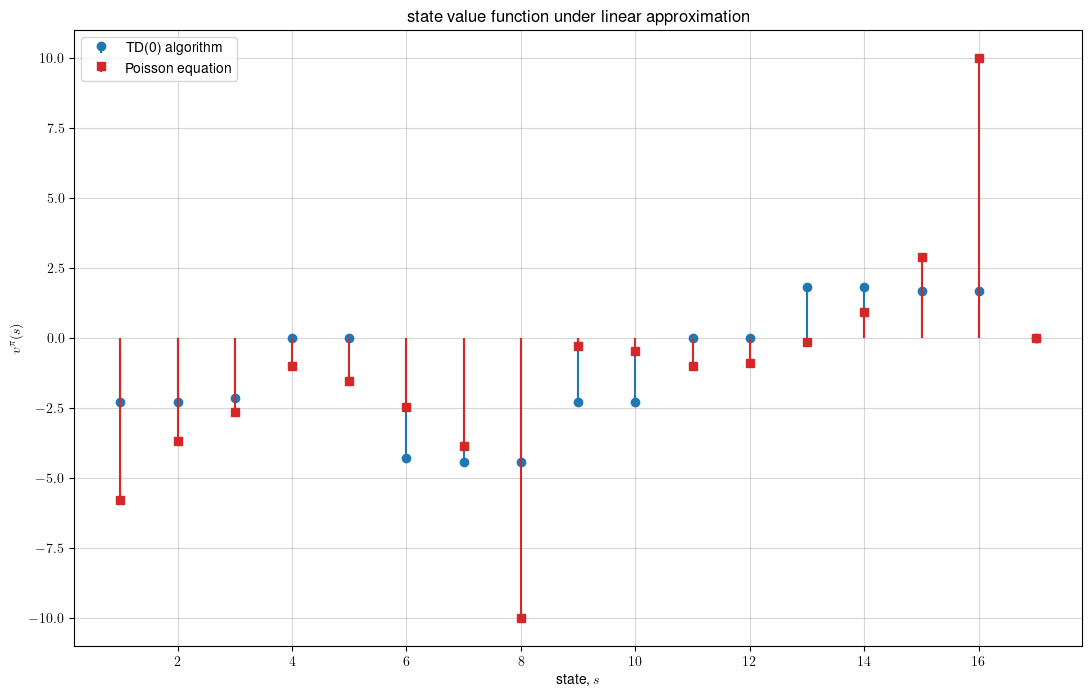

In [14]:
# plots figure 2 or figure 3 (state-value function using TD(0) with linear approximation)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=13, 8
fig = plt.figure()

ax = fig.add_subplot(111)

markerline, stemlines, baseline = ax.stem(states, vpi, label="TD(0) algorithm")
markerline_, stemlines_, baseline_ = ax.stem(states, vpi_poisson, label="Poisson equation")
plt.setp(stemlines_, 'color', 'tab:red')
plt.setp(stemlines, 'linewidth', 1.5)
plt.setp(baseline, 'linewidth', 0)
plt.setp(markerline_, 'color', 'tab:red')
plt.setp(stemlines_, 'linewidth', 1.5)
plt.setp(baseline_, 'linewidth', 0)
plt.setp(markerline_, 'marker', 's')
ax.set_title("state value function under linear approximation")
ax.set_ylabel("$v^{\pi}(s)$")
ax.set_xlabel("state, $s$")
plt.legend()
plt.grid(zorder=0, alpha=0.5)

plt.savefig("figs/fig-2.pdf", format="pdf", bbox_inches="tight")

plt.plot()

**Figure 48.2** State-value function $v^{\pi}(s)$ estimated by running the TD(0) algorithm (48.11) over $20,000$ episodes using the features defined in (48.13). The figure also shows the state--values obtained from the Poisson equation (44.72)  when the MDP parameters are assumed known.

There is an implicit assumption that, for this selection of feature vectors, the state--value function $v^{\pi}(s)$ can be well  approximated by a linear functional of the form $h^{\sf T} w^o$, for some weight vector $w^o$. This assumption is not always true and different constructions for the feature vectors would lead to different approximations for the state--value function. To illustrate this effect, we evaluate $v^{\pi}(s)$ in two ways for comparison purposes. In the first method, we assume knowledge of the MDP parameters $\{\pi(a|s), {\cal P}(s,a,s')\}$ and compute the true  $v^{\pi}(s)$ by using the Poisson equation (44.72) with $\gamma=0.9$; the computer code determines $\{r^{\pi},P^{\pi}\}$ and finds $v^{\pi}(s)$. We listed these values earlier in (46.55). In the second method, we employ the TD(0) algorithm (48.11) using the above feature construction and run it over $20,000$ episodes using the constant step-size value $\mu=0.01$ and setting $v_{-1}^{\pi}(s)$ to random initial values. Figure 48.2 plots the estimated state--values. It is clear from this simulation that the feature vectors used in (48.13)  are not well-representative of the evolution of the game. 

 
We consider next a more extreme construction for the feature vectors by relying on a hot-encoded representation, where $h$ now has dimensions $17\times 1$ with the $j$th entry of $h$ set to $1$ if the agent is located at the $j$th square and $0$  otherwise; the only exception is the last row of $H$ corresponding to the EXIT state $s=17$, where the feature vector is all $0$. We can view this construction as taking a screen-shot of the game and identifying the location of the agent in the image. Constructions of this type are viable only for small state-space dimensions; otherwise, one needs to resort to reduced feature representations. In this way, we end up with the new feature matrix:

$$
H=\begin{array}{|ccccccccccccccccc|}
1 &0 &0 &0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0 &1 &0 &0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0 &0 &1 &0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0 &0 &0 &1&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0 &0 &0 &0&1&0&0&0&0&0&0&0&0&0&0&0&0\\
0 &0 &0 &0&0&1&0&0&0&0&0&0&0&0&0&0&0\\
0 &0 &0 &0&0&0&1&0&0&0&0&0&0&0&0&0&0\\
0 &0 &0 &0&0&0&0&1&0&0&0&0&0&0&0&0&0\\
0 &0 &0 &0&0&0&0&0&1&0&0&0&0&0&0&0&0\\
0 &0 &0 &0&0&0&0&0&0&1&0&0&0&0&0&0&0\\
0 &0 &0 &0&0&0&0&0&0&0&1&0&0&0&0&0&0\\
0 &0 &0 &0&0&0&0&0&0&0&0&1&0&0&0&0&0\\
0 &0 &0 &0&0&0&0&0&0&0&0&0&1&0&0&0&0\\
0 &0 &0 &0&0&0&0&0&0&0&0&0&0&1&0&0&0\\
0 &0 &0 &0&0&0&0&0&0&0&0&0&0&0&1&0&0\\
0 &0 &0 &0&0&0&0&0&0&0&0&0&0&0&0&1&0\\
0 &0 &0 &0&0&0&0&0&0&0&0&0&0&0&0&0&0
\end{array}\begin{array}{l}\leftarrow 1\\\leftarrow2\\\leftarrow3\\\leftarrow4\\\leftarrow5\\\leftarrow6\\\leftarrow7\\\leftarrow8\\\leftarrow9\\\leftarrow10\\\leftarrow11\\\leftarrow12\\\leftarrow13\\\leftarrow14\\\leftarrow15\\\leftarrow16\\\leftarrow17\end{array} \tag{48.14}
$$

Figure 48.3 plots the estimated state--values for these new feature vectors; the simulation shows an improved match between the estimates and the true values. Of course, this second construction  amounts, for all practical purposes, to assuming knowledge of the state values. The example is meant to show that the performance of state--value estimation algorithms  is dependent on the selection of the feature space. 

In [15]:
# TD(0) algorithm under linear value approximation

E = 2000 # number of episodes
delta = 0
gamma = 0.9
mu = 0.01 # step-size
max_episode_duration = 50
use_reduced_features = 0 # # set to zero to use the one-hot encoded extended feature

if use_reduced_features == 1:
    H = Hr
    M = Mr
else:
    H = He 
    M = Me

w = np.zeros(M) # weight vector
kernel = np.zeros(NS)

for e in range(E): # iterates over episodes
    counter = 0
    sample = 1
    while sample == 1:
        idx = np.random.randint(NS-1)+1 # select a random non-exit sate index
        if (idx != 4) and (idx != 11) and (idx != 17): # excluding the block locations and exit state
            s = states[idx-1]
            sample = 0
    
    while (s != 17) and (counter < max_episode_duration): # state s different from EXIT state
        h = H[s, :].T # feature vector
        policy = Pi[:, s] # pi(a|s) is s-th column of Pi matrix
        act = select_action(policy)

        for j in range(NS):
            kernel[j] = P[s, act, j]
        
        sprime = select_next_state(kernel)
        hprime = H[sprime, :].T

        r = reward[s] # in this example reward is only state s-dependent
        delta = r + (gamma*hprime - h).T@w
        w += mu*delta*h 
        s = sprime
        counter += 1

vpi = np.zeros(NS) # NS is the number of states
vpi[3] = 0
vpi[10] = 0 # these are the locations of the blocks
for s in range(NS):
    if (s!=4) and (s!=11):
        h = H[s, :].T
        vpi[s] = h.T@w

# finding state value function from Poisson equation for comparison purposes
vpi_poisson = (np.linalg.inv(np.eye(NS)-gamma*Ppi))@rpi

[]

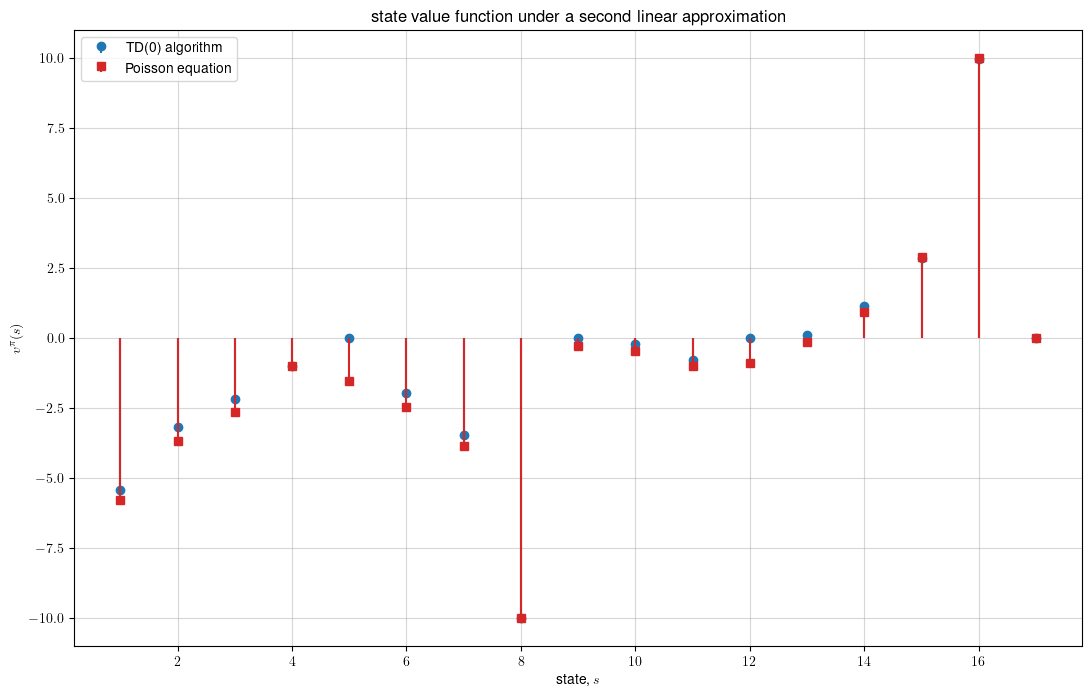

In [16]:
# plots figure 2 or figure 3 (state-value function using TD(0) with linear approximation)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=13, 8
fig = plt.figure()

ax = fig.add_subplot(111)

markerline, stemlines, baseline = ax.stem(states, vpi, label="TD(0) algorithm")
markerline_, stemlines_, baseline_ = ax.stem(states, vpi_poisson, label="Poisson equation")
plt.setp(stemlines_, 'color', 'tab:red')
plt.setp(stemlines, 'linewidth', 1.5)
plt.setp(baseline, 'linewidth', 0)
plt.setp(markerline_, 'color', 'tab:red')
plt.setp(stemlines_, 'linewidth', 1.5)
plt.setp(baseline_, 'linewidth', 0)
plt.setp(markerline_, 'marker', 's')
ax.set_title("state value function under a second linear approximation")
ax.set_ylabel("$v^{\pi}(s)$")
ax.set_xlabel("state, $s$")
plt.legend()
plt.grid(zorder=0, alpha=0.5)

plt.savefig("figs/fig-3.pdf", format="pdf", bbox_inches="tight")

plt.plot()

**Figure 48.3** State-value function $v^{\pi}(s)$ estimated by running the TD(0) algorithm (48.11) over $20,000$ episodes using the extended feature representation (48.14). The figure also shows the state--values obtained from the Poisson equation (44.72)  when the MDP parameters are assumed known.

## Example 48.3 (Playing a game over a grid)

We illustrate the operation of the deep $Q-$learning algorithm (48.119)   by reconsidering the earlier grid problem from  Fig. 48.1. For this example, we do not implement a replay buffer but train the network directly using constructions (48.115) and 
(48.116).
 
 
We consider a feedforward neural network with $L=4$ layers (including one input layer, one output layer, and two hidden layers). All neurons employ the ReLU activation function except for the output layer, where the neurons employ linear activation. The step size, regularization, and discount factor parameters are set to 

$$
\mu=0.00001, \;\;\rho=0.001,\;\;\gamma=0.9 \tag{48.120}
$$

We employ the same one-hot encoded feature vectors (48.14) from Example 48.1. As explained in that example, the feature vectors do not incorporate a constant bias value of $+1$ since the state value function at the EXIT state $s=17$ is zero, i.e., $v^{\pi}(17)=0$. For this reason, we will only be training the weight parameters $\{W_{\ell}\}$ for the network layers; there is no need for the offset parameters $\{\theta_{\ell}\}$ for this example. The input layer has $M=17$ neurons while the output layer has $|\mathbb{A}|=5$ neurons. The two hidden layers have $n_2=32=n_3$ neurons each. We train the network using $E=50,000$ episodes and batches of size $B=1$ (single samples). For each episode, we generate a random state $s$ (and the corresponding feature $h_s$), and update the parameters of the network using constructions (48.115) and 
(48.116). Subsequently, we move from $s$ to a new state $s'$ using an $\epsilon-$greedy exploration policy with $\epsilon=0.1$ and feed $s'$ (i.e., its feature vector $h_{s'}$) into the network, and repeat this process until the end of the episode. We continue to the next episode and so forth. \\

After convergence, we fix the network parameters at $\{W_{\ell}^{\star}\}$. Then, for each state $s$, we feed the corresponding feature vector $h_s$ through the trained network and determine the corresponding output vector $y_s$. The entries of this vector approximate the optimal state--action values $q^{\star}(s,a_k)$ for all actions $a_k\in\mathbb{A}$ at state $s$. The entry with the largest value over the set of {\em permissible} actions at state $s$ identifies the optimal action at that state. 

We collect the  resulting "optimal" state--action values $q^{\star}(s,a)$ into a matrix $Q^{\star}$ with each row corresponding to a state value and each column to an action:

$$
Q^{\star}=\begin{array}{c|rrrr|r}
&\textnormal{ up}&\textnormal{ down}&\textnormal{ left}&\textnormal{ right}&\textnormal{ stop}\\\hline
s=1&-5.4262 &   \fbox{4.7707} &   2.2983  &  2.7980  & -0.0034\\
s=2&3.8333  &  4.0790  &  3.5466   & \fbox{4.8131}   & 0.0499\\
s=3&3.6247  &  3.1124  &  3.4883   & \fbox{3.6524}   &-0.0673\\
s=4&-       &  -       &  -        & -        & -\\
s=5&\fbox{4.8261}  &  3.7703  &  4.2803   & 4.0417   &-0.0296\\
s=6&3.8548  &  3.3647  &  \fbox{4.1220}   & 3.3806   &-0.1519\\
s=7&3.8548  &  2.0752  &  \fbox{3.9053}   &-4.5246   & 0.5266\\
s=8&-  &  -  &  -   &-   & \fbox{0.0012}\\
s=9&\fbox{9.7817}  & -3.9148  &  5.2275   & 5.5454   & 0.0265\\
s=10&\fbox{8.7231}  &  5.8284  &  6.7440   & 7.5686   &-0.0193\\
s=11&-       &  -       &  -        & -        & -\\
s=12&\fbox{5.6183}  &  4.4485  &  4.7203   & 5.0721   &-0.0521\\
s=13&6.0812  &  5.4040  &  5.6415   & \fbox{6.5038}   &-0.0640\\
s=14&7.1153  &  7.1385  &  6.3988   & \fbox{8.0406}   &-0.0077\\
s=15&8.5392  &  7.7579  &  7.4839   & \fbox{9.5775}   & 0.0423\\
s=16&-  & -  &  -   &-   & \fbox{0.0498}\\
s=17&-       &  -       &  -        & -        & \fbox{0}\end{array} \tag{48.121}
$$

The resulting optimal actions are represented by arrows in Fig. 48.6. 

We repeat the simulation by using instead the reduced feature vectors (48.13) leading to the outcome shown in Fig. 48.7. Observe that the "optimal" action at state $s=1$ is not plausible since it leads the agent directly into the danger zone. This is a reflection of the fact that the reduced feature vectors for this example are not discriminatory enough. For example, observe from (48.13) that both states $s=1$ and $s=9$ have the $\textit{same}$ feature representation; by moving upward, one state leads to danger while the other state leads to success.

In [4]:
# deep Q-learning

E = 300000 # number of episodes
delta = 0
gamma = 0.9
mu = 0.00001 # step-size
epsilon = 0.1 # epsilon-greedy factor
rho = 0.001 # regularization parameter
max_episode_duration = 50 # plays role of Ne
use_reduced_features = 0 # set to zero to use the one-hot encoded extended feature

if use_reduced_features == 1:
    H = Hr 
    M = Mr 
else:
    H = He 
    M = Me

# parameters of neural network
L = 4 # number of neural network layers
n1 = M # number of neurons in input layer = size of features vectors without bias entry
n2 = 32 # number of neurons in first hidden layer
n3 = 32 # number of neurons in second hidden layer
n4 = NA # number of neurons in output layer = number of actions available
type_activation = [-1, 3, 3, 0] # -1: irrelevant (not used), 0: linear, 1: sigmopid, 2: tanh, 3: rectifier

W1 = (1/np.sqrt(n1))*np.random.randn(n2, n1) # weight matrices
W2 = (1/np.sqrt(n2))*np.random.randn(n3, n2)
W3 = (1/np.sqrt(n3))*np.random.randn(n4, n3)
Wcell = [W1, W2, W3] # a cell array containing the weight matrices of different dimensions
Wcell_before = Wcell.copy()

theta1 = np.random.randn(n2) # bias vectors; NOT USED in this simulation
theta2 = np.random.randn(n3)
theta3 = np.random.randn(n4)
ThetaCell = [theta1, theta2, theta3] # a cell array for the thetas
ThetaCell_before = ThetaCell.copy()

use_theta = 0 # flag = 0 ==> do not use bias parameters theta; otherwise, set = 1

for e in tqdm(range(E)): # iterates over episodes
    counter = 0
    sample = 1 # select initial sample of episodes to feed into network

    while sample == 1:
        idx = np.random.randint(NS-1)+1 # select a random non-exit state index
        if (idx != 4) and (idx != 11) and (idx != 17): # excluding the block locations and exit state
            s = states[idx-1]
            sample = 0
    while (s!=17) and (counter < max_episode_duration): # state s different from EXIT
        # feedforward h through network
        h = H[s, :].T # feature vector
        yCell = [] # to save the y vectors across layers
        zCell = [] # to save the z vectors across layers
        yCell, zCell = feed_forward(Wcell,ThetaCell,L,type_activation,h,use_theta)
        yL = yCell[-1] # output vector corresponding to h

        # generation of output reference vector for different actions
        output = np.zeros(NA)
        yCellb = []
        zCellb = []
        yb = np.zeros(NA)
        for a in range(NA): # reapeat for every possible action
            policy = Pi[:, s] # pi(a|s) is s-th column of Pi matrix
            if policy[a] > 0: # this action is possible at state s
                act = a # set action to a
                kernel = np.zeros(NS)
                for j in range(NS):
                    kernel[j] = P[s, act, j] # transition probabilities from state s
                sprime = select_next_state(kernel) # next state under action a 
                hprime = H[sprime, :].T # next feature vector
                
                if sprime == 16: # exit state
                    output[a] = reward[15]
                
                if sprime == 8: # another exit state
                    output[a] = reward[7]
                
                if (sprime != 8) and (sprime != 16):
                    # feed hprme through network
                    yCellb, zCellb = feed_forward(Wcell,ThetaCell,L,type_activation,hprime,use_theta)
                    yb = yCellb[-1]
                    output[a] = reward[sprime] + gamma*np.linalg.norm(yb, ord=np.inf) # using infinity norm
        sigmaL = 2*(yL - output)
        Wcellf = []
        ThetaCellf = []
        Wcellf, ThetaCellf = feed_back(Wcell,ThetaCell,yCell,zCell,L,type_activation,sigmaL,mu,rho,use_theta)
        Wcell = Wcellf.copy()
        ThetaCell = ThetaCellf.copy()

        # epsilon-greedy exploration to determine which state to feed next into the neural network

        policy = Pi[:, s] # policy vector at state s --> determines which actions are possible at s
        counter2 = 0
        q_vec = np.zeros(NA)
        a_vec = np.zeros(NA)
        for j in range(NA):
            if policy[j] > 0: # the j-th action is possible
                q_vec[counter2] = yL[j] # q-values at state s
                a_vec [counter2] = j # corresponding valid action
                counter2 += 1
        ax = np.argmax(q_vec[0:counter2]) # permissible action at s with largest q-value
        idx = (q_vec[:counter2]).max()
        act1 = int(a_vec[ax]) # index of the permissible action

        yx = np.random.rand() # epsilom-greedy strategy
        if yx <= epsilon:
            ay = np.random.randint(counter2) # choose from actions permissible at state s
            act = a_vec[ay]
        else:
            act = act1

        for j in range(NS):
            kernel[j] = P[s, int(act), j]
        sprime = select_next_state(kernel)
        s = sprime
        counter += 1

# once training is complete, we feed features corresponding to the various states and determine the optimar action

Wstar = []
Thetastar = []
Wstar = Wcell.copy()
Thetastar = ThetaCell.copy()

Q = np.zeros((NS, NA))
act = np.zeros(NS)
action_states = [None]*NS
for s in range(NS):
    if (s!=3) and (s!=10): # not valid states
        h = H[s, :].T # feature vector
        yCell, zCell = feed_forward(Wstar,Thetastar,L,type_activation,h,use_theta)
        yL = yCell[-1] # contains Q(s, a) for all actions
        Q[s, :] = yL
        pi_vec = Pi[:, s] # policy vector at state s --> determines which actions are possible at s
        counter = 0
        for j in range(NA):
            if pi_vec[j] > 0: # the j-th action is possible
                q_vec[counter] = yL[j] # q-value
                a_vec[counter] = j # corresponding valid action
                counter += 1
        ax = np.argmax(q_vec[0:counter]) # permissible action at s with largest q-value
        idx = (q_vec[:counter]).max()
        act[s] = int(a_vec[ax]) # index of the permissible action
        action_states[s] = actions[int(act[s])]
        print(s+1, action_states[s])

print(Q)

100%|██████████| 300000/300000 [42:20<00:00, 118.07it/s]


1 left
2 up
3 up
5 up
6 left
7 up
8 stop
9 up
10 up
12 up
13 right
14 right
15 right
16 stop
17 stop
[[ 8.87430829e-01  3.42012857e+00  3.44807773e+00  2.25485896e+00
   1.31640630e-01]
 [ 5.75547980e+00  4.73280094e+00  5.27831547e+00  3.94993631e+00
  -9.90704684e-02]
 [ 5.74680023e+00  5.05087192e+00  5.26598620e+00  5.55107660e+00
   1.17428152e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 8.50531049e+00  7.52005318e+00  7.71140708e+00  6.70839477e+00
   6.65836586e-03]
 [ 6.42629876e+00  5.79998786e+00  6.92026004e+00  6.17768153e+00
  -1.41178192e-02]
 [ 7.35067462e+00  4.46267266e+00  6.30772022e+00  1.51156312e+00
  -4.59286401e-02]
 [ 3.41783010e-02  5.41972039e-02  1.32230456e-01 -5.56353121e-02
   9.85843600e+00]
 [ 1.36627323e+01 -7.72832298e-01  9.45123253e+00 -4.60421279e+00
   7.03086509e-02]
 [ 1.06926477e+01  4.54249867e+00  9.88936733e+00 -3.58376846e+00
  -1.83075808e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00